# Prophet modeling

Here we'll try to mimic the same process of finding the best train-test split, but for Facebook's Prophet library. Let's import everything.

In [1]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from sklearn.linear_model import LinearRegression
from iexfinance.stocks import Stock
import random
import pandas as pd
import matplotlib.pyplot as plt
import pandas.tseries
import datetime as dt
from datetime import date
from datetime import timedelta 
import yfinance as yf
import requests
from pandas.plotting import lag_plot
from pandas import datetime
import re
from tiingo import TiingoClient
import json
from pandas_datareader import data as pdr

In [2]:
yf.__version__

'0.1.63'

### The test case: C
Just like the previous notebook, we'll try to run through a simple test case and expand it to other stocks. We'll use Citicgroup again.

Quick note: I encountered a bug with my earlier library, yfinance, so I've had to switch to tiingo, so a lot of code will be hashed out from earlier. And in case I can get the bugs worked out.

In [3]:
c = yf.Ticker("C")

In [4]:
df=c.history(period="2y")

In [5]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-08-05,61.193141,61.398363,60.241665,60.801357,21144800,0.0,0
2019-08-06,61.566267,61.874100,60.474867,61.799473,12411500,0.0,0
2019-08-07,60.288308,60.931958,59.364816,60.764050,18418300,0.0,0
2019-08-08,61.426339,62.303194,61.221117,62.256550,13577900,0.0,0
2019-08-09,61.874093,62.097968,60.829329,61.612904,13604600,0.0,0


In [6]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-08-05,61.193141,61.398363,60.241665,60.801357,21144800,0.0,0
2019-08-06,61.566267,61.874100,60.474867,61.799473,12411500,0.0,0
2019-08-07,60.288308,60.931958,59.364816,60.764050,18418300,0.0,0
2019-08-08,61.426339,62.303194,61.221117,62.256550,13577900,0.0,0
2019-08-09,61.874093,62.097968,60.829329,61.612904,13604600,0.0,0


One of the data cleaning aspects of Prophet is that it requires the time periods to be in strings. I want to make this as simple as possible (i.e. just input a number), so here I'll look to transform some potential inputs into Prophet format.

In [7]:
deltas=['d','m','y']
att='200d'

In [8]:
att[-1]

'd'

In [9]:
spl=len(att)-1
att[:spl]

'200'

In [10]:
end=att[:spl] + ' days'
end

'200 days'

So let's get a dataframe with our close price so we can test modeling it.

In [11]:
df1=df['Close']

In [12]:
df1.head()

Date
2019-08-05    60.801357
2019-08-06    61.799473
2019-08-07    60.764050
2019-08-08    62.256550
2019-08-09    61.612904
Name: Close, dtype: float64

In [13]:
df1=df1.to_frame()

In [14]:
# instantiate Prophet
prof_1 = Prophet(daily_seasonality=True, yearly_seasonality=True)

In [15]:
df1.head()

,Close
Date,
2019-08-05,60.801357
2019-08-06,61.799473
2019-08-07,60.764050
2019-08-08,62.256550
2019-08-09,61.612904


Prophet requires the dataframe to be in a certain format, let's get it that way now.

In [16]:
df1.index.names = ['ds']
df1.columns=['y']

In [17]:
df1.reset_index(level=0, inplace=True)

In [18]:
df1.head()

,ds,y
0,2019-08-05,60.801357
1,2019-08-06,61.799473
2,2019-08-07,60.764050
3,2019-08-08,62.256550
4,2019-08-09,61.612904


In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      504 non-null    datetime64[ns]
 1   y       504 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


In [20]:
prof_1.fit(df1)

In [21]:
#Create a new dataframe for the predictions, 3 weeks out
future = prof_1.make_future_dataframe(periods=21)

In [22]:
forecast = prof_1.predict(future)

In [23]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
520,2021-08-20,68.267361,62.364401,71.711882,67.934749,68.523518,-1.237113,-1.237113,-1.237113,0.05992,...,-0.032221,-0.032221,-0.032221,-1.264811,-1.264811,-1.264811,0.0,0.0,0.0,67.030248
521,2021-08-21,68.281255,62.535134,71.424529,67.911889,68.594402,-1.322664,-1.322664,-1.322664,0.05992,...,-0.007490,-0.007490,-0.007490,-1.375093,-1.375093,-1.375093,0.0,0.0,0.0,66.958591
522,2021-08-22,68.295149,62.345419,71.344428,67.879011,68.657887,-1.425161,-1.425161,-1.425161,0.05992,...,-0.007490,-0.007490,-0.007490,-1.477591,-1.477591,-1.477591,0.0,0.0,0.0,66.869988
523,2021-08-23,68.309044,61.912220,71.655689,67.839100,68.721467,-1.412362,-1.412362,-1.412362,0.05992,...,0.100137,0.100137,0.100137,-1.572419,-1.572419,-1.572419,0.0,0.0,0.0,66.896681
524,2021-08-24,68.322938,62.107482,71.258398,67.801953,68.790806,-1.673165,-1.673165,-1.673165,0.05992,...,-0.073166,-0.073166,-0.073166,-1.659918,-1.659918,-1.659918,0.0,0.0,0.0,66.649773


In [24]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          525 non-null    datetime64[ns]
 1   trend                       525 non-null    float64       
 2   yhat_lower                  525 non-null    float64       
 3   yhat_upper                  525 non-null    float64       
 4   trend_lower                 525 non-null    float64       
 5   trend_upper                 525 non-null    float64       
 6   additive_terms              525 non-null    float64       
 7   additive_terms_lower        525 non-null    float64       
 8   additive_terms_upper        525 non-null    float64       
 9   daily                       525 non-null    float64       
 10  daily_lower                 525 non-null    float64       
 11  daily_upper                 525 non-null    float64       

In [25]:
proph_pred=forecast['yhat']

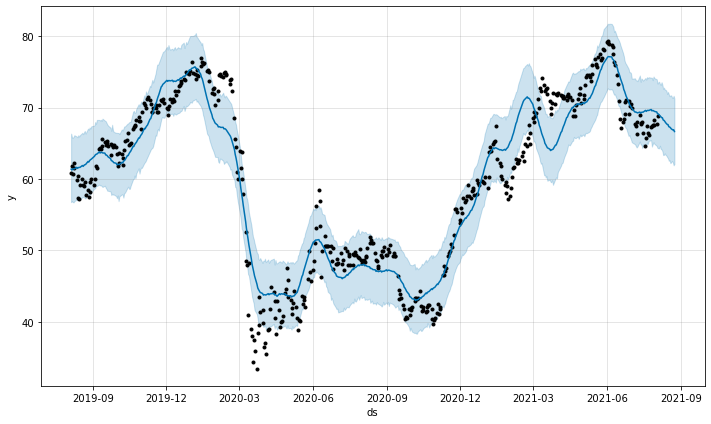

In [26]:
prof_1.plot(forecast)
plt.show()

Thankfully, Prophet has its own cross validation and performance metrics functions to see how well the model performed.

In [27]:
df1_cv = cross_validation(prof_1, initial='30 days', period='1 days', horizon = '14 days')

INFO:prophet:Making 686 forecasts with cutoffs between 2019-09-04 00:00:00 and 2021-07-20 00:00:00


  0%|          | 0/686 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

In [28]:
df1_pm = performance_metrics(df1_cv)

In [29]:
trains=['30 days','60 days','180 days']
tests=['7 days','14 days']

In [30]:
df1_pm.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
8,10 days,708.396596,26.615721,15.584340,0.257049,0.154739,0.262983,0.172758
9,11 days,1077.200705,32.820736,18.163820,0.298277,0.163035,0.298560,0.162788
10,12 days,1670.998155,40.877844,21.331844,0.347984,0.163163,0.330071,0.163094
11,13 days,2095.208052,45.773443,23.585374,0.383391,0.166343,0.348293,0.158863
12,14 days,2624.437041,51.229260,26.115164,0.422288,0.170746,0.366759,0.156448


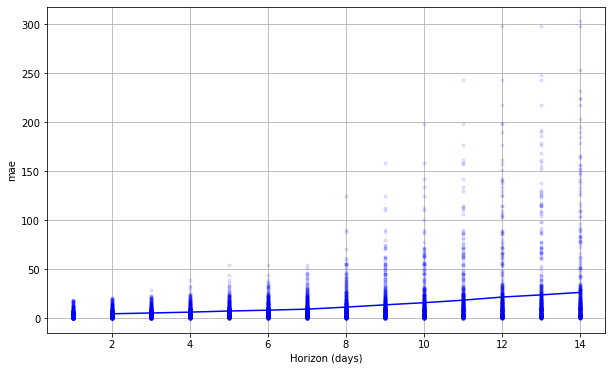

In [31]:
fig = plot_cross_validation_metric(df1_cv, metric='mae')

## STONKS (Again)!!!

Just like in the ARIMA notebook, I want to test a number of train-test splits with Prophet. Since it works a little different from ARIMA, the code will be a little different, but still borrowing a lot. Here, we can import our stock symbols, and clean them up.

In [32]:
sp_500=pd.read_csv('Data/constituents_csv.csv')
nsdq=pd.read_csv('Data/nasdaq.csv')
dow_30=pd.read_excel('Data/dow-jones-industrial-average-components.xls')

Again, we'll be doing the same things we did in the ARIMA notebook to make the data model-friendly. Like changing the names of the columns in the Dow dataframe.

In [33]:
new_cols=['Name','Symbol','Weight%']
dow_30.columns=new_cols

In [34]:
nsdq.head()

,Unnamed: 0,Symbol,Company Name
0,1,AAL,"American Airlines Group, Inc."
1,2,AAME,Atlantic American Corporation
2,3,AAOI,"Applied Optoelectronics, Inc."
3,4,AAON,"AAON, Inc."
4,5,AAPL,Apple Inc.


In [35]:
nsdq.drop(columns='Unnamed: 0',inplace=True)

In [36]:
len(nsdq)

1701

Again, like the ARIMA notebook, this code is to find all the bad stocks (delisted) in the NASDAQ csv file. I've hashed it out because I saved the csv, so it should work just fine. But I kept the code in case I run this in the future and it doesn't work.

In [37]:
#no_data=[]
#for each in nsdq['Symbol']:
#    x=yf.Ticker(each)
#    df=x.history(period='1d')
#    if len(df)==0:
#        no_data.append(each)

In [38]:
#len(no_data)

In [39]:
#nd_index=[]
#for each in no_data:
#    y=nsdq.loc[nsdq['Symbol']==each].index
#    nd_index.append(y[0])

In [40]:
#nsdq = nsdq.drop(labels=nd_index,drop=True, axis=0)
#nsdq.reset_index()

In [41]:
#nsdq.to_csv("/Users/Daniel/Documents/Flatiron/Capstone/Project/nasdaq.csv")

In [42]:
def tt_test_p (asset,train_val,test_val):
    """This function will take in a financial asset (stock, etf, as a string) as well as 2 lists of integers (training and testing days).
    Then the asset will be looked up through yahoo finance and gather the price history. It will then run through the values
    of the training and testing lists and run prophet models on all of them. It will record the metrics and return a
    dataframe with all the results."""
    
    stock = yf.Ticker(asset)
    df1=stock.history(period='1y')
    print("Processing: ",stock)
    prof_1 = Prophet(daily_seasonality=True, yearly_seasonality=True)
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof_1.fit(df1)
    future = prof_1.make_future_dataframe(periods=14)
    forecast = prof_1.predict(future)
    for train_val in trains:
        for test_val in tests:
            df1_cv = cross_validation(prof_1, initial=train_val, period='1 days', horizon = test_val)
            df1_pm = performance_metrics(df1_cv)
            print('Training: ', train_val)
            print('Testing: ', test_val)
            print (df1_pm.tail())             

    return forecast

In [43]:
cols2=['Symbol','Train_Len','Test_Len','MAE','RMSE']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()

,index,Symbol,Train_Len,Test_Len,MAE,RMSE


In [44]:
results_CAT=tt_test_p('CAT',trains,tests)

Processing:  yfinance.Ticker object <CAT>


INFO:prophet:Making 328 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-07-27 00:00:00


  0%|          | 0/328 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   317.237723  17.811168  14.239748  0.075192  0.056638  0.074894   
3  4 days   562.571507  23.718590  19.077743  0.101273  0.082723  0.101006   
4  5 days   938.942701  30.642172  24.482679  0.131240  0.101526  0.132553   
5  6 days  1391.340581  37.300678  29.146991  0.158029  0.114836  0.163535   
6  7 days  2288.854841  47.841978  36.358471  0.198461  0.132797  0.212785   

   coverage  
2  0.137168  
3  0.137168  
4  0.119469  
5  0.106195  
6  0.088496  


  0%|          | 0/321 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
8  10 days  12065.430352  109.842753   79.481933  0.443920  0.268827   
9  11 days  17229.950420  131.262906   95.000350  0.531911  0.323520   
10 12 days  24902.059199  157.803863  113.028945  0.634394  0.349536   
11 13 days  34933.308085  186.904543  130.845407  0.738764  0.398833   
12 14 days  47485.113160  217.910792  148.505635  0.841495  0.369823   

       smape  coverage  
8   0.440157  0.038044  
9   0.496958  0.037304  
10  0.559694  0.049098  
11  0.607810  0.044590  
12  0.646863  0.031015  


  0%|          | 0/298 [00:00<?, ?it/s]

INFO:prophet:Making 291 forecasts with cutoffs between 2020-10-03 00:00:00 and 2021-07-20 00:00:00


Training:  60 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   302.804179  17.401269  13.782396  0.069888  0.055163  0.070182   
3  4 days   532.218684  23.069865  18.395090  0.093560  0.079689  0.094755   
4  5 days   878.445927  29.638588  23.589877  0.121141  0.096528  0.124811   
5  6 days  1272.697427  35.674885  27.581536  0.142919  0.104242  0.148239   
6  7 days  2062.086772  45.410206  33.966957  0.176925  0.125132  0.187936   

   coverage  
2  0.160194  
3  0.156098  
4  0.122549  
5  0.112745  
6  0.098039  


  0%|          | 0/291 [00:00<?, ?it/s]

INFO:prophet:Making 178 forecasts with cutoffs between 2021-01-31 00:00:00 and 2021-07-27 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
8  10 days  10303.580399  101.506553   73.107211  0.391111  0.252126   
9  11 days  14300.197707  119.583434   85.887449  0.459296  0.268827   
10 12 days  20246.239912  142.289282  100.993194  0.540672  0.338022   
11 13 days  27463.387837  165.720813  114.776833  0.616178  0.356709   
12 14 days  37503.494329  193.658189  129.484589  0.697977  0.354018   

       smape  coverage  
8   0.406558  0.041994  
9   0.455322  0.044937  
10  0.506837  0.052330  
11  0.543278  0.048108  
12  0.576568  0.030889  


  0%|          | 0/178 [00:00<?, ?it/s]

INFO:prophet:Making 171 forecasts with cutoffs between 2021-01-31 00:00:00 and 2021-07-20 00:00:00


Training:  180 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   309.340762  17.588086  14.270664  0.065365  0.055645  0.065805   
3  4 days   526.912412  22.954573  18.457258  0.084528  0.073343  0.085351   
4  5 days   743.233789  27.262314  22.117854  0.101236  0.090483  0.101718   
5  6 days   881.238083  29.685654  24.020261  0.109805  0.091335  0.110217   
6  7 days  1235.640860  35.151684  27.916653  0.127171  0.102973  0.129374   

   coverage  
2  0.169355  
3  0.154472  
4  0.163934  
5  0.155738  
6  0.113821  


  0%|          | 0/171 [00:00<?, ?it/s]

Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
8  10 days  3769.509458  61.396331  48.749029  0.221178  0.212934  0.233976   
9  11 days  5102.962464  71.435023  56.704838  0.257303  0.257644  0.276871   
10 12 days  6529.988835  80.808346  64.867142  0.293623  0.260189  0.313857   
11 13 days  7367.534397  85.834343  69.122660  0.312323  0.276769  0.330714   
12 14 days  8408.050210  91.695421  72.768689  0.328835  0.313372  0.345726   

    coverage  
8   0.064884  
9   0.073695  
10  0.094915  
11  0.078322  
12  0.049780  


In [45]:
results_MMM=tt_test_p('MMM',trains,tests)

Processing:  yfinance.Ticker object <MMM>


INFO:prophet:Making 328 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-07-27 00:00:00


  0%|          | 0/328 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   139.466210  11.809581   8.349757  0.048127  0.031713  0.047792   
3  4 days   279.335031  16.713319  11.306432  0.065510  0.043007  0.065028   
4  5 days   534.676578  23.123075  14.759982  0.085979  0.053371  0.086109   
5  6 days   836.300062  28.918853  18.654586  0.109228  0.062942  0.111375   
6  7 days  1585.800818  39.822115  25.029876  0.147186  0.077217  0.156173   

   coverage  
2  0.230088  
3  0.181416  
4  0.141593  
5  0.106195  
6  0.088496  


  0%|          | 0/321 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
8  10 days  10976.326996  104.767967   57.082954  0.339667  0.135933   
9  11 days  16618.004267  128.910838   68.016814  0.405356  0.132414   
10 12 days  23779.116989  154.204789   78.244871  0.466481  0.144581   
11 13 days  30715.055614  175.257113   90.270134  0.537170  0.170846   
12 14 days  42388.054849  205.883595  107.976232  0.641144  0.154714   

       smape  coverage  
8   0.327688  0.018627  
9   0.357311  0.019986  
10  0.382902  0.025832  
11  0.409527  0.020677  
12  0.444054  0.014863  


INFO:prophet:Making 298 forecasts with cutoffs between 2020-10-03 00:00:00 and 2021-07-27 00:00:00


  0%|          | 0/298 [00:00<?, ?it/s]

INFO:prophet:Making 291 forecasts with cutoffs between 2020-10-03 00:00:00 and 2021-07-20 00:00:00


Training:  60 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   105.664869  10.279342   7.555554  0.042627  0.030875  0.042743   
3  4 days   193.762692  13.919867   9.982810  0.056490  0.039897  0.056911   
4  5 days   380.842129  19.515177  12.923577  0.073578  0.050095  0.075337   
5  6 days   646.819158  25.432640  16.342198  0.093775  0.057218  0.097567   
6  7 days  1168.770695  34.187288  21.602745  0.124519  0.072167  0.134029   

   coverage  
2  0.237864  
3  0.180488  
4  0.156863  
5  0.117647  
6  0.093137  


  0%|          | 0/291 [00:00<?, ?it/s]

INFO:prophet:Making 178 forecasts with cutoffs between 2021-01-31 00:00:00 and 2021-07-27 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
8  10 days   6783.394970   82.361368  45.735213  0.266663  0.125816  0.270930   
9  11 days   9349.044843   96.690459  52.113672  0.304047  0.137946  0.292475   
10 12 days  13560.905458  116.451301  59.524967  0.347727  0.144581  0.317978   
11 13 days  19442.240448  139.435435  70.514030  0.412237  0.159719  0.344488   
12 14 days  28164.262483  167.822116  85.829953  0.501671  0.153406  0.379597   

    coverage  
8   0.016905  
9   0.020739  
10  0.028674  
11  0.019398  
12  0.015075  


  0%|          | 0/178 [00:00<?, ?it/s]

INFO:prophet:Making 171 forecasts with cutoffs between 2021-01-31 00:00:00 and 2021-07-20 00:00:00


Training:  180 days
Testing:  7 days
  horizon         mse       rmse        mae      mape     mdape     smape  \
2  3 days   52.969184   7.277993   5.755069  0.029829  0.024873  0.029652   
3  4 days   80.152006   8.952765   7.125394  0.036884  0.032786  0.036658   
4  5 days  109.216671  10.450678   8.338567  0.043146  0.035153  0.043050   
5  6 days  129.601070  11.384247   9.332779  0.048214  0.040037  0.048163   
6  7 days  192.925185  13.889751  11.259884  0.058074  0.054553  0.057732   

   coverage  
2  0.266129  
3  0.235772  
4  0.196721  
5  0.139344  
6  0.146341  


  0%|          | 0/171 [00:00<?, ?it/s]

Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
8  10 days   542.687478  23.295654  19.169271  0.098512  0.091363  0.097542   
9  11 days   681.454041  26.104675  21.389466  0.109816  0.099595  0.108489   
10 12 days   809.272844  28.447721  23.393312  0.120019  0.099364  0.119370   
11 13 days   931.399593  30.518840  25.322030  0.129786  0.114424  0.129481   
12 14 days  1149.351429  33.902086  28.103998  0.143925  0.118140  0.142564   

    coverage  
8   0.028520  
9   0.029030  
10  0.040164  
11  0.036674  
12  0.027920  


In [46]:
results_AXP=tt_test_p('AXP',trains,tests)

Processing:  yfinance.Ticker object <AXP>


INFO:prophet:Making 328 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-07-27 00:00:00


  0%|          | 0/328 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   234.686084  15.319467  11.762519  0.095693  0.075089  0.095854   
3  4 days   470.578094  21.692812  16.357233  0.134409  0.100106  0.135424   
4  5 days   825.576878  28.732854  21.034906  0.174678  0.125905  0.183292   
5  6 days  1277.009494  35.735270  25.643243  0.214847  0.140364  0.231832   
6  7 days  2278.788748  47.736660  33.749117  0.285066  0.165691  0.309098   

   coverage  
2  0.221239  
3  0.168142  
4  0.146018  
5  0.132743  
6  0.079646  


  0%|          | 0/321 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
8  10 days  11623.804649  107.813750   71.257586  0.611005  0.306464   
9  11 days  17093.551857  130.742311   85.298104  0.734192  0.326580   
10 12 days  25033.285288  158.219105  100.865282  0.870922  0.370810   
11 13 days  35237.141452  187.715587  117.674047  1.019692  0.443866   
12 14 days  49984.055934  223.571143  138.617226  1.205960  0.382699   

       smape  coverage  
8   0.519949  0.030298  
9   0.573523  0.025059  
10  0.625700  0.016123  
11  0.661512  0.013575  
12  0.697163  0.016811  


INFO:prophet:Making 298 forecasts with cutoffs between 2020-10-03 00:00:00 and 2021-07-27 00:00:00


  0%|          | 0/298 [00:00<?, ?it/s]

Training:  60 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   205.792217  14.345460  10.969570  0.085589  0.068914  0.086403   
3  4 days   400.018310  20.000458  14.984839  0.117595  0.091284  0.119605   
4  5 days   697.811550  26.416123  19.194053  0.152339  0.116789  0.161057   
5  6 days  1150.739996  33.922559  23.710730  0.191219  0.129900  0.208136   
6  7 days  2060.069056  45.387984  31.076956  0.253302  0.152527  0.279164   

   coverage  
2  0.242718  
3  0.180488  
4  0.161765  
5  0.147059  
6  0.098039  


INFO:prophet:Making 291 forecasts with cutoffs between 2020-10-03 00:00:00 and 2021-07-20 00:00:00


  0%|          | 0/291 [00:00<?, ?it/s]

INFO:prophet:Making 178 forecasts with cutoffs between 2021-01-31 00:00:00 and 2021-07-27 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
8  10 days   8989.488806   94.812915   61.515406  0.504792  0.269059   
9  11 days  12446.591823  111.564295   71.180259  0.582947  0.317844   
10 12 days  18097.593445  134.527296   83.193666  0.682536  0.345210   
11 13 days  27509.288231  165.859242   99.006596  0.819216  0.359396   
12 14 days  41409.277334  203.492696  119.198857  0.995337  0.395569   

       smape  coverage  
8   0.447346  0.033435  
9   0.482875  0.027782  
10  0.522844  0.017921  
11  0.564309  0.015075  
12  0.613903  0.018660  


  0%|          | 0/178 [00:00<?, ?it/s]

INFO:prophet:Making 171 forecasts with cutoffs between 2021-01-31 00:00:00 and 2021-07-20 00:00:00


Training:  180 days
Testing:  7 days
  horizon         mse       rmse        mae      mape     mdape     smape  \
2  3 days  133.866005  11.570048   9.253562  0.061569  0.055821  0.061605   
3  4 days  213.817074  14.622485  12.000246  0.079691  0.076645  0.079824   
4  5 days  304.461797  17.448834  14.445195  0.095892  0.094823  0.096397   
5  6 days  355.420519  18.852600  15.721353  0.104314  0.108521  0.105203   
6  7 days  480.907766  21.929609  18.576661  0.123174  0.122032  0.124670   

   coverage  
2  0.290323  
3  0.219512  
4  0.180328  
5  0.163934  
6  0.105691  


  0%|          | 0/171 [00:00<?, ?it/s]

Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
8  10 days  1609.614532  40.120002  34.745598  0.229241  0.217868  0.232873   
9  11 days  2112.956631  45.966908  40.266285  0.264872  0.278872  0.269252   
10 12 days  2613.031026  51.117815  45.129421  0.296803  0.268731  0.303224   
11 13 days  2963.091609  54.434287  48.072893  0.316239  0.296081  0.326333   
12 14 days  3379.226737  58.131117  51.133547  0.335813  0.338476  0.351059   

    coverage  
8   0.031271  
9   0.021696  
10  0.010991  
11  0.008547  
12  0.014556  


In [47]:
results_AAPL=tt_test_p('AAPL',trains,tests)

Processing:  yfinance.Ticker object <AAPL>


INFO:prophet:Making 329 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-07-28 00:00:00


  0%|          | 0/329 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   257.987451  16.061988   9.074407  0.075452  0.034706  0.083260   
3  4 days   532.323417  23.072135  12.805230  0.107217  0.046654  0.120555   
4  5 days   822.086030  28.672043  16.132481  0.135413  0.049690  0.149729   
5  6 days  1010.179628  31.783323  18.304776  0.152992  0.058665  0.167556   
6  7 days  1917.221734  43.786091  23.354981  0.195325  0.065717  0.203541   

   coverage  
2  0.336283  
3  0.309735  
4  0.268722  
5  0.255507  
6  0.198238  


  0%|          | 0/322 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  14 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
8  10 days  11715.373906  108.237581  56.272280  0.473956  0.098170  0.409145   
9  11 days  18894.352279  137.456729  71.916302  0.608052  0.111304  0.453094   
10 12 days  25774.392920  160.544053  83.071226  0.702429  0.113476  0.465833   
11 13 days  29318.273225  171.225796  87.894920  0.740604  0.116963  0.467048   
12 14 days  37208.017225  192.893798  96.981716  0.816259  0.115875  0.486779   

    coverage  
8   0.142197  
9   0.117059  
10  0.104882  
11  0.100378  
12  0.105551  


  0%|          | 0/299 [00:00<?, ?it/s]

INFO:prophet:Making 292 forecasts with cutoffs between 2020-10-03 00:00:00 and 2021-07-21 00:00:00


Training:  60 days
Testing:  7 days
  horizon         mse       rmse        mae      mape     mdape     smape  \
2  3 days  101.330277  10.066294   6.826193  0.054876  0.032387  0.054346   
3  4 days  194.258169  13.937653   9.088669  0.073205  0.042229  0.072188   
4  5 days  322.266848  17.951792  11.245297  0.090738  0.043689  0.089540   
5  6 days  500.780281  22.378121  13.601082  0.109786  0.052612  0.109940   
6  7 days  871.646168  29.523654  17.242325  0.139431  0.057897  0.146302   

   coverage  
2  0.359223  
3  0.336585  
4  0.292683  
5  0.273171  
6  0.229268  


  0%|          | 0/292 [00:00<?, ?it/s]

INFO:prophet:Making 179 forecasts with cutoffs between 2021-01-31 00:00:00 and 2021-07-28 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
8  10 days   4600.995561   67.830639  38.138929  0.310799  0.084571  0.330964   
9  11 days   6994.624200   83.633870  46.297488  0.377062  0.098410  0.353417   
10 12 days   9714.912614   98.564256  52.205505  0.424035  0.104187  0.358865   
11 13 days  13060.957473  114.284546  58.202623  0.471944  0.106996  0.371873   
12 14 days  18417.070617  135.709508  67.397464  0.547124  0.102374  0.399026   

    coverage  
8   0.149664  
9   0.116222  
10  0.112143  
11  0.115000  
12  0.111429  


  0%|          | 0/179 [00:00<?, ?it/s]

INFO:prophet:Making 172 forecasts with cutoffs between 2021-01-31 00:00:00 and 2021-07-21 00:00:00


Training:  180 days
Testing:  7 days
  horizon        mse      rmse       mae      mape     mdape     smape  \
2  3 days  21.971001  4.687323  3.808883  0.029194  0.027881  0.029179   
3  4 days  32.354374  5.688091  4.453454  0.034108  0.028851  0.034136   
4  5 days  38.983029  6.243639  4.912519  0.037625  0.029021  0.037615   
5  6 days  46.380583  6.810329  5.312764  0.040763  0.032167  0.040781   
6  7 days  71.493801  8.455401  6.229608  0.047815  0.038383  0.048087   

   coverage  
2  0.451613  
3  0.463415  
4  0.390244  
5  0.398374  
6  0.314516  


  0%|          | 0/172 [00:00<?, ?it/s]

Training:  180 days
Testing:  14 days
   horizon         mse       rmse        mae      mape     mdape     smape  \
8  10 days  169.176108  13.006772   9.172336  0.070405  0.054218  0.070598   
9  11 days  207.628845  14.409332  10.132537  0.078061  0.055001  0.078082   
10 12 days  209.342448  14.468671  10.581511  0.081755  0.055254  0.080961   
11 13 days  196.187225  14.006685  10.646274  0.082294  0.068379  0.081000   
12 14 days  226.104552  15.036773  11.269481  0.086951  0.070751  0.086233   

    coverage  
8   0.228464  
9   0.205326  
10  0.203390  
11  0.191342  
12  0.179293  


In [48]:
results_AMGN=tt_test_p('AMGN',trains,tests)

Processing:  yfinance.Ticker object <AMGN>


INFO:prophet:Making 329 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-07-28 00:00:00


  0%|          | 0/329 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   697.028328  26.401294  17.019189  0.072132  0.039548  0.073922   
3  4 days  1476.517578  38.425481  25.006889  0.106392  0.055441  0.111827   
4  5 days  2854.199007  53.424704  34.846998  0.148548  0.067905  0.158660   
5  6 days  3809.941316  61.724722  40.740864  0.173849  0.087543  0.184828   
6  7 days  5923.655424  76.965287  50.267864  0.214796  0.096128  0.226235   

   coverage  
2  0.261062  
3  0.185841  
4  0.127753  
5  0.132159  
6  0.088106  


INFO:prophet:Making 322 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-07-21 00:00:00


  0%|          | 0/322 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Training:  30 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
8  10 days   36526.751344  191.119730  116.282505  0.499867  0.188803   
9  11 days   56683.920558  238.083852  143.374660  0.617823  0.209003   
10 12 days   88657.520666  297.754128  176.812374  0.763967  0.253955   
11 13 days  117816.160966  343.243588  203.577841  0.881016  0.314034   
12 14 days  153352.260205  391.602171  230.381137  0.998008  0.312605   

       smape  coverage  
8   0.463455  0.066289  
9   0.521640  0.051439  
10  0.563231  0.048271  
11  0.599792  0.036646  
12  0.639770  0.037983  


  0%|          | 0/299 [00:00<?, ?it/s]

Training:  60 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   638.727288  25.273055  15.714963  0.066899  0.037270  0.068785   
3  4 days  1332.879278  36.508619  22.879113  0.097888  0.048395  0.103376   
4  5 days  2423.438054  49.228427  30.864290  0.132567  0.061129  0.142107   
5  6 days  3027.421036  55.022005  35.353267  0.152254  0.073403  0.163873   
6  7 days  4375.359269  66.146499  42.917341  0.185212  0.087963  0.197987   

   coverage  
2  0.286408  
3  0.214634  
4  0.146341  
5  0.156098  
6  0.107317  


INFO:prophet:Making 292 forecasts with cutoffs between 2020-10-03 00:00:00 and 2021-07-21 00:00:00


  0%|          | 0/292 [00:00<?, ?it/s]

INFO:prophet:Making 179 forecasts with cutoffs between 2021-01-31 00:00:00 and 2021-07-28 00:00:00


Training:  60 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
8  10 days   26703.500597  163.412058   97.339230  0.423950  0.151502   
9  11 days   42451.034517  206.036488  119.446988  0.521688  0.176207   
10 12 days   64744.238891  254.448892  144.514507  0.633047  0.182425   
11 13 days   82588.907282  287.382858  162.984761  0.715307  0.228898   
12 14 days  103669.178356  321.976984  181.546037  0.797832  0.272031   

       smape  coverage  
8   0.414280  0.069554  
9   0.459022  0.059186  
10  0.494992  0.062143  
11  0.527841  0.050714  
12  0.559617  0.045000  


  0%|          | 0/179 [00:00<?, ?it/s]

INFO:prophet:Making 172 forecasts with cutoffs between 2021-01-31 00:00:00 and 2021-07-21 00:00:00


Training:  180 days
Testing:  7 days
  horizon          mse       rmse        mae      mape     mdape     smape  \
2  3 days   289.243059  17.007147  11.293797  0.046381  0.030973  0.047263   
3  4 days   487.047396  22.069150  14.822891  0.060836  0.038715  0.062500   
4  5 days   669.776211  25.880035  17.896663  0.073349  0.046176  0.075383   
5  6 days   747.469679  27.339892  19.117548  0.078379  0.053004  0.080489   
6  7 days  1063.831131  32.616424  22.405572  0.092026  0.056816  0.096033   

   coverage  
2  0.338710  
3  0.235772  
4  0.170732  
5  0.203252  
6  0.145161  


  0%|          | 0/172 [00:00<?, ?it/s]

Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
8  10 days  3745.880488  61.203599  41.387717  0.169805  0.094178  0.186073   
9  11 days  5158.781300  71.824657  49.023697  0.201240  0.114379  0.225824   
10 12 days  6301.002160  79.378852  55.070009  0.225941  0.149275  0.253718   
11 13 days  6870.596826  82.889063  58.141203  0.238651  0.146760  0.268899   
12 14 days  7964.498955  89.244042  61.430445  0.252463  0.146760  0.288236   

    coverage  
8   0.089859  
9   0.062873  
10  0.056872  
11  0.035226  
12  0.043343  


After looking over these results, it seems unlike ARIMA, Prophet likes the 180/7 split. 

In [76]:
stocks=['MMM','AXP','AMGN','AAPL','CAT']
cv_cols=['horizon','mse','rmse','mae','mape','mdape','smape','coverage']

In [79]:
df_y=pd.DataFrame(columns=cv_cols)
for each in stocks:
    stock = yf.Ticker(each)
    df1=stock.history(period='1y')
    print("Processing: ",each)
    prof_1 = Prophet(daily_seasonality=True, yearly_seasonality=True)
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof_1.fit(df1)
    df1_cv = cross_validation(prof_1, initial='30 days', period='1 days', horizon = '14 days')
    df1_pm = performance_metrics(df1_cv)
    df_ph=df1_pm.sort_values(by=['mae']).head(2)
    df_y=pd.concat([df_y,df_ph])

Processing:  MMM


INFO:prophet:Making 322 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-07-21 00:00:00


  0%|          | 0/322 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Processing:  AXP


INFO:prophet:Making 322 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-07-21 00:00:00


  0%|          | 0/322 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Processing:  AMGN


INFO:prophet:Making 322 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-07-21 00:00:00


  0%|          | 0/322 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Processing:  AAPL


INFO:prophet:Making 322 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-07-21 00:00:00


  0%|          | 0/322 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Processing:  CAT


INFO:prophet:Making 322 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-07-21 00:00:00


  0%|          | 0/322 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

In [80]:
df_y

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,52.764097,7.263890,5.238207,0.029970,0.019928,0.029888,0.385506
1,3 days,119.839458,10.947121,7.715429,0.044474,0.029549,0.044207,0.260648
0,2 days,94.685846,9.730665,7.258065,0.058095,0.039634,0.057968,0.314363
1,3 days,204.149914,14.288104,10.919213,0.088640,0.067578,0.088720,0.232784
0,2 days,259.975489,16.123755,10.186850,0.043158,0.024419,0.043688,0.407459
1,3 days,599.588460,24.486495,15.661054,0.066384,0.038856,0.067878,0.278120
0,2 days,92.461517,9.615691,5.482373,0.045067,0.026104,0.047163,0.474704
1,3 days,220.899762,14.862697,8.364964,0.069461,0.034532,0.075927,0.360823
0,2 days,133.992780,11.575525,8.822443,0.046023,0.035453,0.045970,0.283273
1,3 days,277.175247,16.648581,13.152346,0.069353,0.055988,0.069113,0.169523


### Putting it all together

So let's make us a function! Ultimately, we'll want it to be able to select the best of 4 stocks input by the user. As always, let's start simple.

In [49]:
results_AMGN.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
269,2021-08-21,239.084904,236.063123,247.134345,239.084562,239.085215,2.415503,2.415503,2.415503,-0.539827,...,0.067478,0.067478,0.067478,2.887852,2.887852,2.887852,0.0,0.0,0.0,241.500407
270,2021-08-22,239.091427,236.977703,247.721849,239.091049,239.091777,3.247861,3.247861,3.247861,-0.539827,...,0.067478,0.067478,0.067478,3.720210,3.720210,3.720210,0.0,0.0,0.0,242.339288
271,2021-08-23,239.097950,238.215588,248.776950,239.097534,239.098330,4.090950,4.090950,4.090950,-0.539827,...,0.118866,0.118866,0.118866,4.511911,4.511911,4.511911,0.0,0.0,0.0,243.188900
272,2021-08-24,239.104473,238.676194,249.219295,239.104003,239.104885,4.829282,4.829282,4.829282,-0.539827,...,0.123696,0.123696,0.123696,5.245413,5.245413,5.245413,0.0,0.0,0.0,243.933755
273,2021-08-25,239.110996,239.118825,249.758222,239.110480,239.111454,5.269481,5.269481,5.269481,-0.539827,...,-0.095744,-0.095744,-0.095744,5.905052,5.905052,5.905052,0.0,0.0,0.0,244.380476


In [50]:
pred_cols=['ds','yhat']

In [51]:
AMGN_preds=results_AMGN[pred_cols]

In [52]:
AMGN_preds.tail()

,ds,yhat
269,2021-08-21,241.500407
270,2021-08-22,242.339288
271,2021-08-23,243.188900
272,2021-08-24,243.933755
273,2021-08-25,244.380476


In [53]:
AMGN_preds=AMGN_preds.tail(21)

In [54]:
AMGN_preds.head()

,ds,yhat
253,2021-08-05,235.980591
254,2021-08-06,236.002167
255,2021-08-07,235.496276
256,2021-08-08,235.189921
257,2021-08-09,235.066197


In [55]:
AMGN_preds.reset_index(level=0, drop=True,inplace=True)

In [56]:
AMGN_preds.head()

,ds,yhat
0,2021-08-05,235.980591
1,2021-08-06,236.002167
2,2021-08-07,235.496276
3,2021-08-08,235.189921
4,2021-08-09,235.066197


In [57]:
AMGN_preds['yhat'][20]

244.38047643943617

In [58]:
AMGN_preds['yhat'][0]

235.98059115901373

In [59]:
change_percent=((AMGN_preds['yhat'][20]-AMGN_preds['yhat'][0])/AMGN_preds['yhat'][0])*100

In [60]:
change_percent=round(change_percent,3)

In [61]:
change_percent

3.56

Now let's put this together into a simple function. It will take the yhat predictions and calculate the percentage return.

In [62]:
def pct_change(df):
    """This function will take a Prophet forecast dataframe and quickly calculate the percentage change.
    One that has been produced from the earlier Prophet function"""
    df1=df['yhat']
    df1=df1.tail(14)
    df1.reset_index(level=0, drop=True,inplace=True)
    change=((df1[13]-df1[0])/df1[0])*100
    change=round(change, 2)
    if change >0:
        print(f"According to the model, you stand to gain {change}% over the next 14 days")
    else:
        change_abs=abs(change)
        print(f"According to the model, you stand to lose {change_abs}% over the next 14 days")
    return None

In [63]:
pct_change(results_AAPL)

According to the model, you stand to gain 7.74% over the next 14 days


In [64]:
pct_change(results_AXP)

According to the model, you stand to gain 1.91% over the next 14 days


In [65]:
pct_change(results_MMM)

According to the model, you stand to gain 2.45% over the next 14 days


In [66]:
pct_change(results_CAT)

According to the model, you stand to gain 2.53% over the next 14 days


Now, let's create a function that will run through the Prophet process, and return the forecast.

In [67]:
def fcast(stock):
    """This function will take a stock( as a string) and perform all the necessary changes to the data to allow Prophet to model
    it and return the forecast dataframe"""
    stock=stock.upper() #make sure the symbol is in uppercase
    prof=Prophet(daily_seasonality=True, yearly_seasonality=True)
    stonk = yf.Ticker(stock)
    df1=stonk.history(period='1y')
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof.fit(df1)
    future = prof.make_future_dataframe(periods=14)
    forecast = prof.predict(future)
    #The next 2 lines are disabled for the final function, but I wanted a few graphs.
#    prof.plot(forecast)
 #   plt.show()
    return forecast

In [68]:
HAL=fcast('HAL')

In [69]:
HAL.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-08-04,15.208723,14.397799,16.092330,15.208723,15.208723,0.040393,0.040393,0.040393,1.002183,...,0.047247,0.047247,0.047247,-1.009037,-1.009037,-1.009037,0.0,0.0,0.0,15.249116
1,2020-08-05,15.223325,14.552520,16.224515,15.223325,15.223325,0.150849,0.150849,0.150849,1.002183,...,0.124678,0.124678,0.124678,-0.976012,-0.976012,-0.976012,0.0,0.0,0.0,15.374174
2,2020-08-06,15.237927,14.478887,16.110173,15.237927,15.237927,0.086589,0.086589,0.086589,1.002183,...,0.024142,0.024142,0.024142,-0.939736,-0.939736,-0.939736,0.0,0.0,0.0,15.324516
3,2020-08-07,15.252529,14.512036,16.276425,15.252529,15.252529,0.115955,0.115955,0.115955,1.002183,...,0.014447,0.014447,0.014447,-0.900674,-0.900674,-0.900674,0.0,0.0,0.0,15.368485
4,2020-08-10,15.296336,14.705964,16.386731,15.296336,15.296336,0.270726,0.270726,0.270726,1.002183,...,0.040031,0.040031,0.040031,-0.771488,-0.771488,-0.771488,0.0,0.0,0.0,15.567062


In [70]:
MMM=fcast('MMM')

In [71]:
AXP=fcast('AXP')

Now the final piece: taking in 4 stocks from the user, running them through the previous functions, and letting us know which one stands to gain the most.

In [72]:
def pred_4():
    """This function will prompt the user to input 4 different stock/ETF symbols. It will then use Prophet 
    to forecast the next 14 days of the stock price, and return the values (in percent) of potential gain and loss."""
    stocks=[]
    pcts=[]
    stock1,stock2,stock3,stock4=input("Enter 4 stock symbols: ").split(",")
    stocks=[stock1,stock2,stock3,stock4]
    print("Working...")
    for stock in stocks:
        stock=stock.upper()
        df=fcast(stock)
        df1=df['yhat']
        df1=df1.tail(14)
        df1.reset_index(level=0, drop=True,inplace=True)
        change=((df1[13]-df1[0])/df1[0])*100
        change=round(change, 2)
        pcts.append(change)
    for i in range(0,4):
        print(f"Stock: {stocks[i].upper()}")
        print(f"Percent Change: {pcts[i]}")
    maxp=pcts.index(max(pcts))
    print()
    print(f'According to the model, {stocks[maxp].upper()} has the highest upside.')
    print("\n" * 3)
    print('FOR ENTERTAINMENT PURPOSES ONLY. This does not substitute for advise from a financial advisor.') 
    print('The creator and affiliates are not responsible for any potential losses. But totally responsible for any gains.')
    return None
    

In [74]:
pred_4()

Enter 4 stock symbols: dis,aapl,amzn,tsla
Working...
Stock: DIS
Percent Change: 0.39
Stock: AAPL
Percent Change: 6.39
Stock: AMZN
Percent Change: 2.44
Stock: TSLA
Percent Change: 17.27

According to the model, TSLA has the highest upside.




FOR ENTERTAINMENT PURPOSES ONLY. This does not substitute for advise from a financial advisor.
The creator and affiliates are not responsible for any potential losses. But totally responsible for any gains.


# Conclusion:

I like to call this the KISSSS (the Keep it Simple Stock Selector-The Last 'S' is a typo), and it's true to its name. It's simple, it provides an answer that investors can use to make their decisions. Now as the disclaimer states, this should not be the only factor used in making any investment decision; but for someone that doesn't want to do a lot of research into their stock purchases, this will fit them just fine.

Personaly, I like Prophet much better than ARIMA. It provided much better numbers and it was built to predict time series that were more random than what ARIMA was built for.